In [1]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, GRU, Dense, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the new models
def build_1d_cnn(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = Conv1D(64, 15, padding='same', activation='relu')(inp)
    x = Conv1D(128, 15, padding='same', activation='relu')(x)
    x = Conv1D(256, 15, padding='same', activation='relu')(x)
    x = Conv1D(1, 15, padding='same', activation='tanh')(x)
    return Model(inp, x)

def build_lstm(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inp)
    x = LSTM(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_gru(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_denoising_autoencoder(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    
    # Encoder
    encoded = Conv1D(128, 15, padding='same', activation='relu')(inp)
    encoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    
    # Decoder without upsampling (maintains the same input/output size)
    decoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    decoded = Conv1D(128, 15, padding='same', activation='relu')(decoded)
    decoded = Conv1D(1, 15, padding='same', activation='tanh')(decoded)
    
    return Model(inp, decoded)

# Ensemble method: averaging predictions from all models
def ensemble_predict(models, noisy_signal):
    predictions = [model.predict(noisy_signal) for model in models]
    ensemble_prediction = np.mean(predictions, axis=0)
    return ensemble_prediction.squeeze()

# Load ECG and noise data
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
# Consider only the relevant classes, other classes are ignored
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}  # Extend this mapping as needed
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1  # Filter out invalid labels

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Split data into 70% training, 15% validation, and 15% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(ecg_segments, mapped_labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Extend and add noise to ECG segments using the SNR formula
def add_noise_to_segments(ecg_segments, noise_signal, target_snr_db):
    noisy_segments = []
    noise_signal = extend_noise_signal(noise_signal, ecg_segments.shape[1])
    
    for ecg_segment in ecg_segments:
        current_snr = calculate_snr(ecg_segment, noise_signal[:len(ecg_segment)])
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function
def denoise_signal(models, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = ensemble_predict(models, noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # You may want to use more features from different levels

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight=class_weight_dict)
    clf.fit(features, labels)
    return clf

# Create combined noise types
combined_noises = {
    'EM+MA': em_noise + ma_noise,
    'EM+BW': em_noise + bw_noise,
    'MA+BW': ma_noise + bw_noise,
    'EM+BW+MA': em_noise + bw_noise + ma_noise
}

# Add single noises to combined noises
noises = {
    'EM': em_noise,
    'BW': bw_noise,
    'MA': ma_noise
}
noises.update(combined_noises)

snr_db = 0  # Example SNR value

# Prepare the clean ECG segments as target data for training
clean_ecg_segments_train = X_train.copy()

# Instantiate the models
models = [
    build_1d_cnn(),
    build_lstm(),
    build_gru(),
    build_denoising_autoencoder()
]

# Train the models separately for each noise type
results = {}

for noise_name, noise_data in noises.items():
    # Initialize and compile each model
    for model in models:
        model.compile(optimizer=Adam(), loss='mse')

    noisy_ecg_slices_train = add_noise_to_segments(X_train, noise_data, snr_db)
    noisy_ecg_slices_val = add_noise_to_segments(X_val, noise_data, snr_db)
    noisy_ecg_slices_test = add_noise_to_segments(X_test, noise_data, snr_db)
    
    noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the models
    noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
    clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

    # Train each model for the current noise type
    for model in models:
        model.fit(noisy_ecg_slices_train_expanded, np.expand_dims(clean_ecg_segments_train, axis=-1), 
                  epochs=5, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

    # Denoise and classify after training
    denoised_ecg_slices_test = denoise_signal(models, noisy_ecg_slices_test)
    
    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    
    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])
    
    test_labels = y_test[:len(features_noisy)]
    
    model_noisy = classify_heartbeats(features_noisy, test_labels)
    model_denoised = classify_heartbeats(features_denoised, test_labels)
    
    # Predict the classes
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)
    
    # Get the unique classes present in test_labels
    unique_classes = np.unique(test_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]
    
    # Evaluate accuracy for each class
    report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)
    
    # Store accuracy and SNR, RMSE for each class
    results[noise_name] = {
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values)
    }

# Output the results for each class and noise condition
for noise_name, metrics in results.items():
    print(f"Noise type: {noise_name}")
    print(f"Average SNR after denoising: {metrics['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {metrics['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in metrics['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in metrics['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")


Epoch 1/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 177s 329ms/step - loss: 0.0860 - val_loss: 0.0412
Epoch 2/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 199s 323ms/step - loss: 0.0426 - val_loss: 0.0382
Epoch 3/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 171s 323ms/step - loss: 0.0420 - val_loss: 0.0340
Epoch 4/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 170s 321ms/step - loss: 0.0376 - val_loss: 0.0333
Epoch 5/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 172s 324ms/step - loss: 0.0397 - val_loss: 0.0329
Epoch 1/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 150s 274ms/step - loss: 0.1590 - val_loss: 0.0586
Epoch 2/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 124s 234ms/step - loss: 0.0565 - val_loss: 0.0376
Epoch 3/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 125s 236ms/step - loss: 0.0375 - val_loss: 0.0471
Epoch 4/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 128s 241ms/step - loss: 0.0451 - val_loss: 0.0329
Epoch 5/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 124s 235ms/step - loss: 0.0638 - val_loss: 0.0493
Epoch 1/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 141s 263ms/step - loss: 0.1575 - val_loss: 0.0574
Epoch 2/5
529/529 ━━━

756/756 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 175s 231ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 139s 184ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step


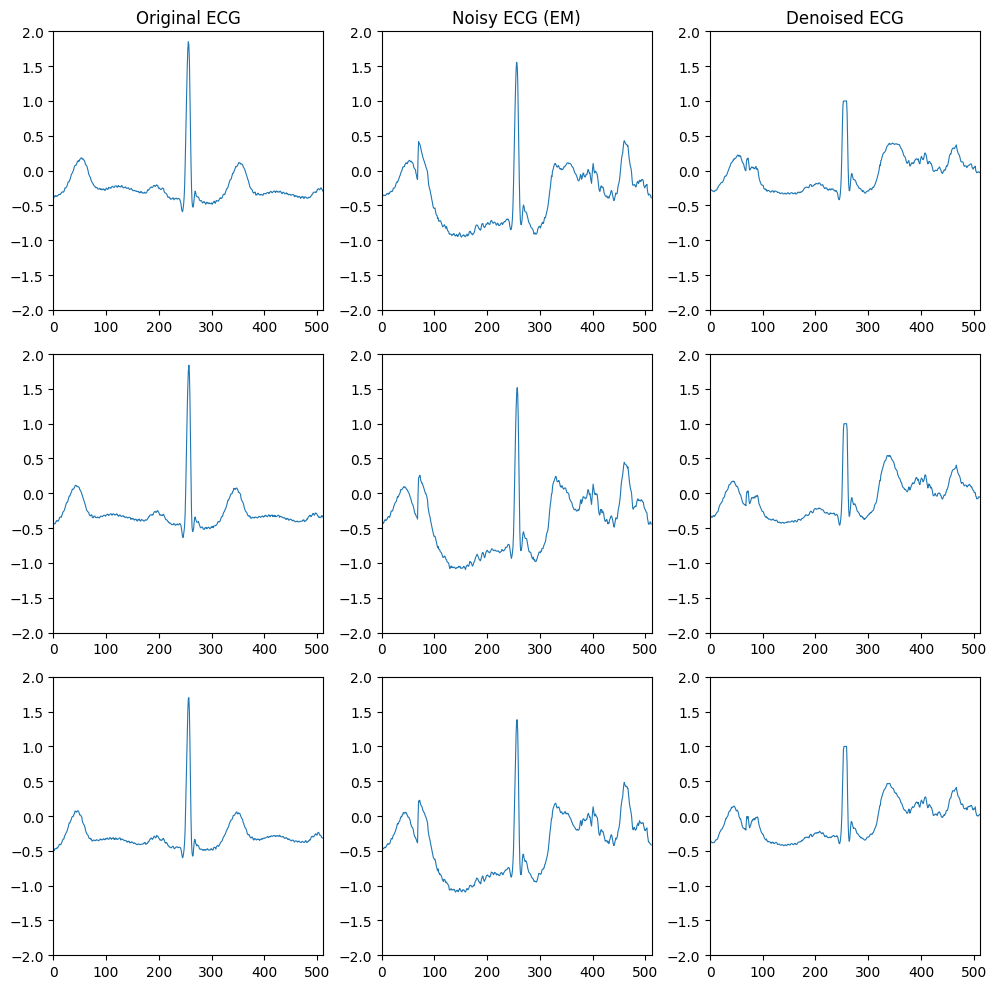

756/756 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 174s 230ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 134s 177ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step


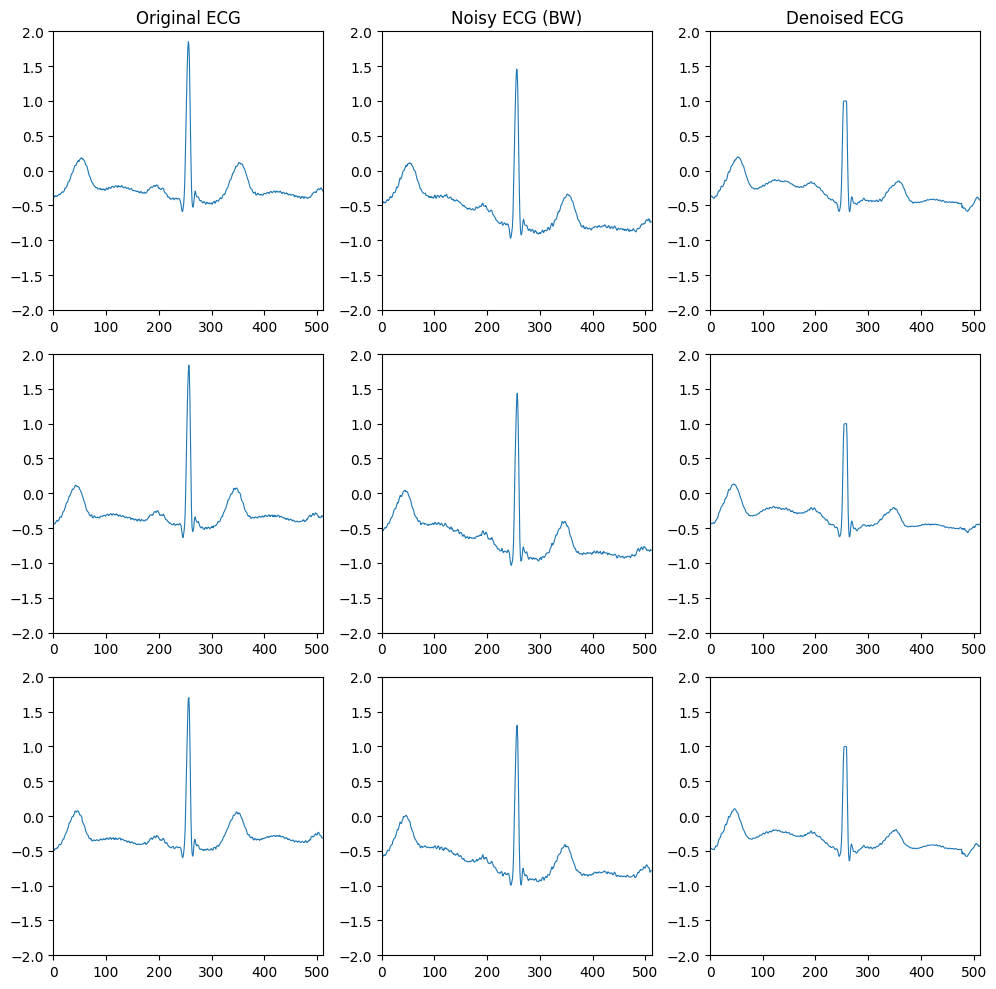

756/756 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 175s 232ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 138s 183ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step


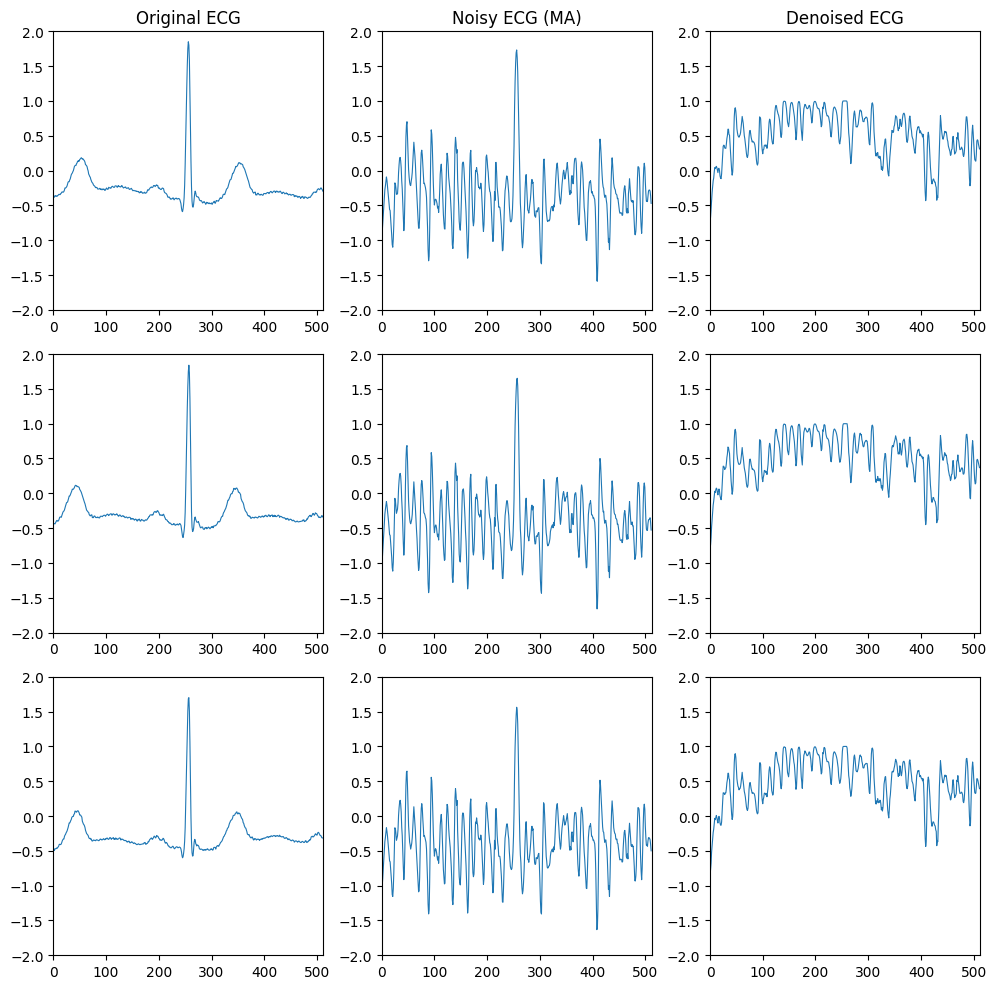

756/756 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 93s 123ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 56s 74ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step


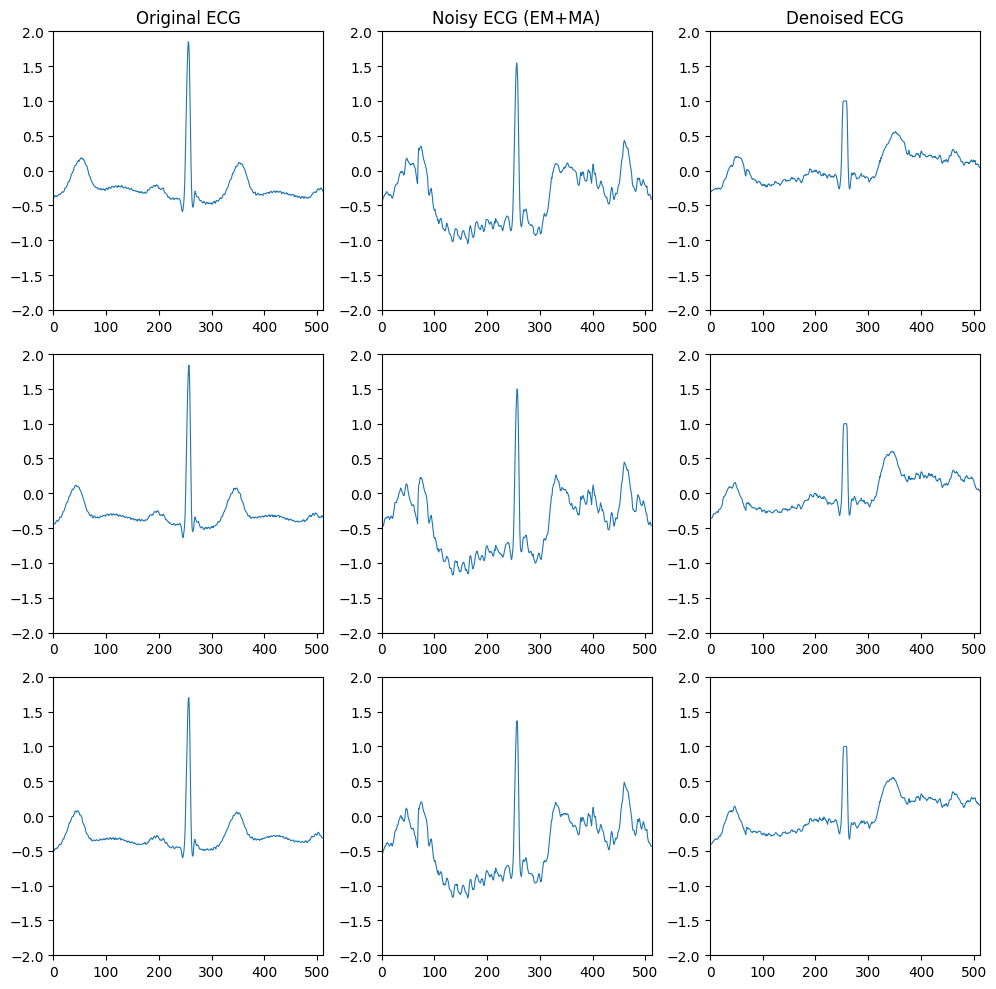

756/756 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 64s 85ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 80s 106ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step


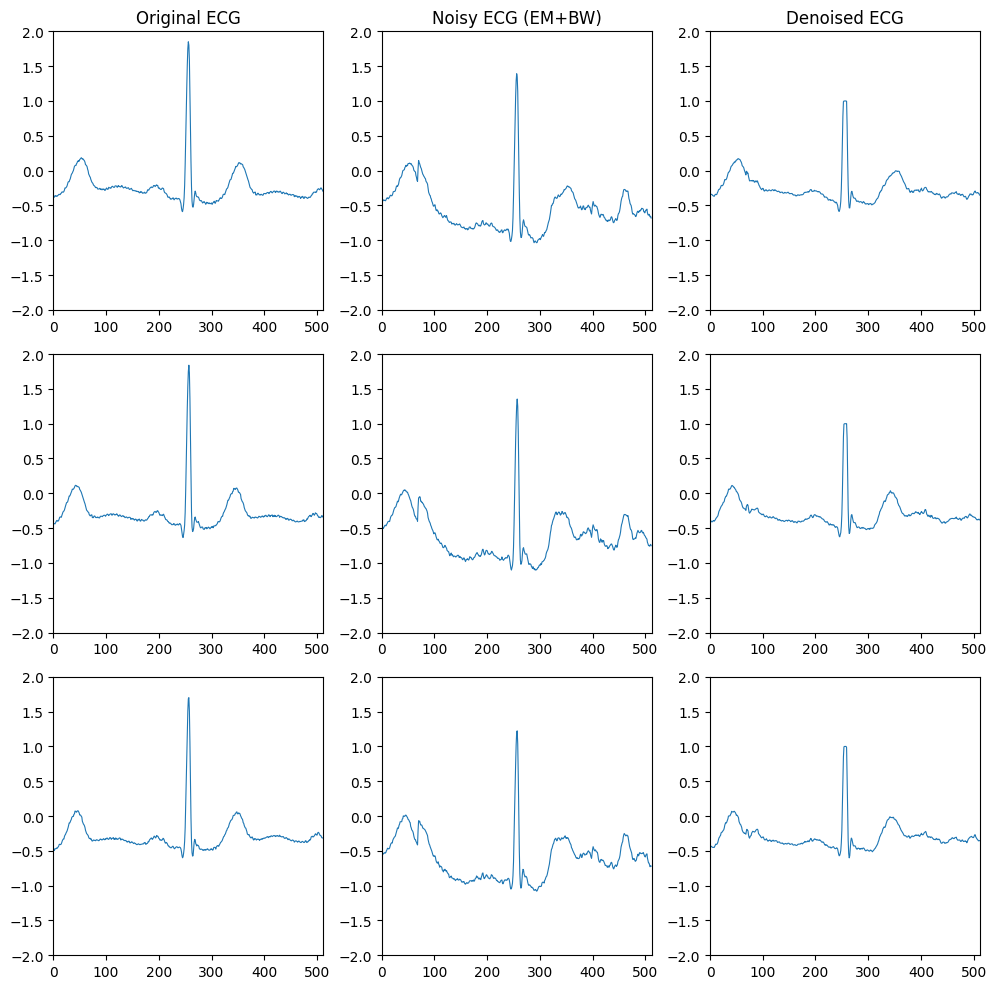

756/756 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 169s 223ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 147s 195ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step


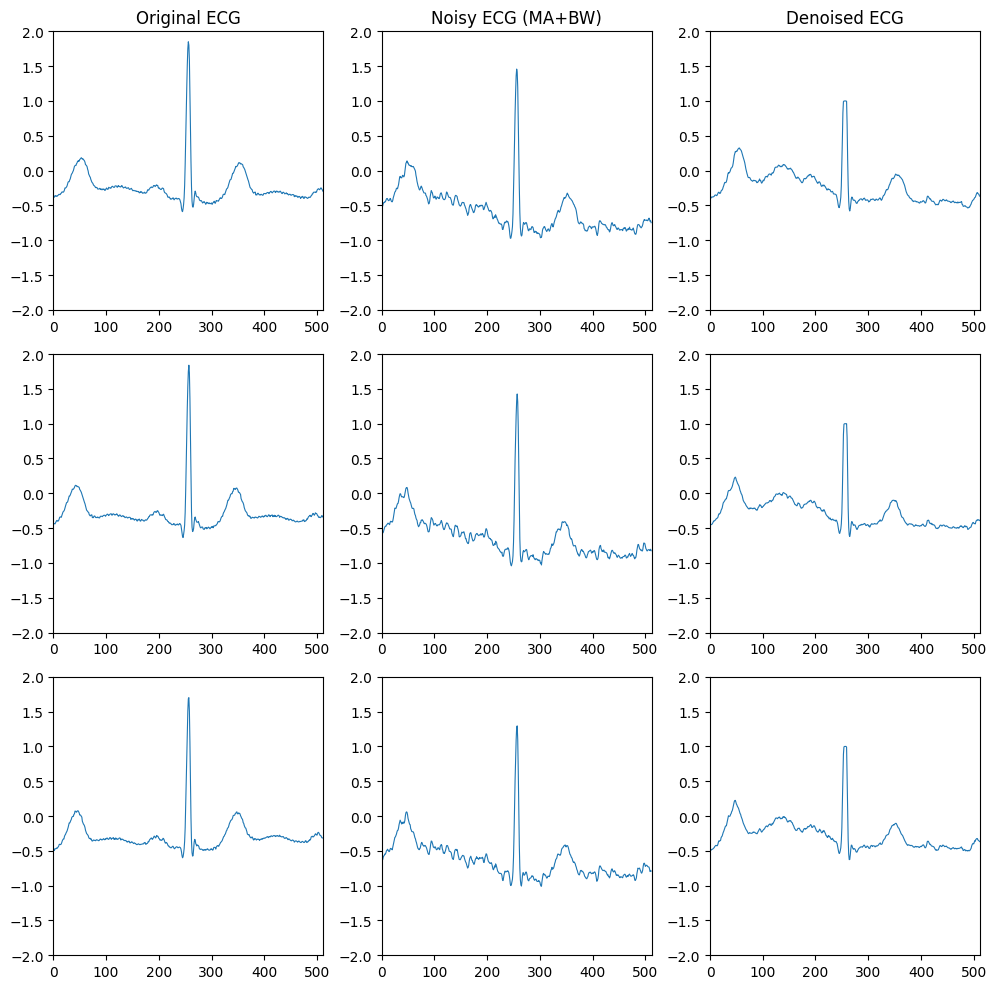

756/756 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 153s 203ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step


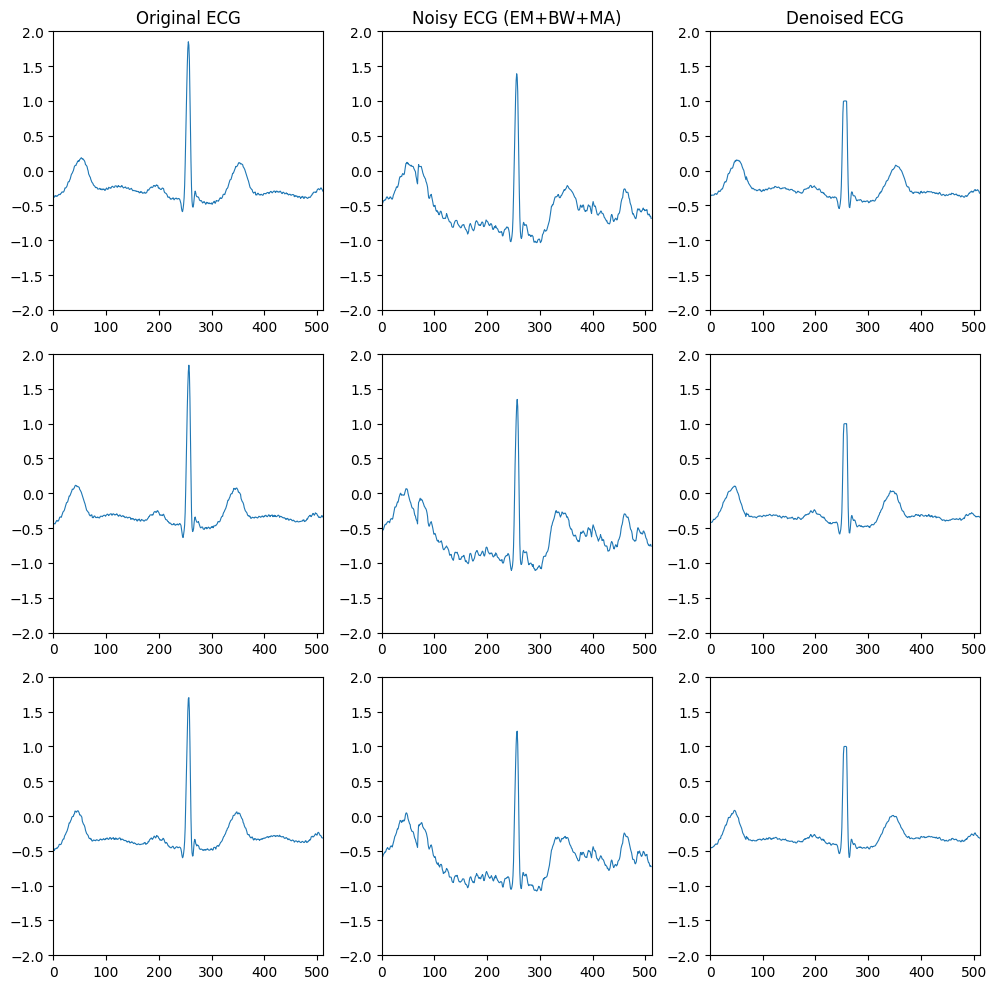

In [4]:
# Plotting function for the noisy and denoised ECG signals
import matplotlib.pyplot as plt
def plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices, num_samples=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot original ECG
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.plot(ecg_segments[i], linewidth=0.8)
        if i == 0:
            plt.title('Original ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(ecg_segments[i])])

        # Plot noisy ECG
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.plot(noisy_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title(f'Noisy ECG ({noise_name})')
        plt.ylim([-2, 2])
        plt.xlim([0, len(noisy_ecg_slices[i])])

        # Plot denoised ECG
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.plot(denoised_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title('Denoised ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(denoised_ecg_slices[i])])

    plt.tight_layout()
    plt.show()

# Plotting for all noise types
for noise_name, noise_data in noises.items():
    noisy_ecg_slices = add_noise_to_segments(ecg_segments, noise_data, snr_db)
    denoised_ecg_slices = denoise_signal(models, noisy_ecg_slices)
    
    # Generate plots
    plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices)